In [1]:
from matplotlib import pyplot as plt 
import cv2
import numpy as np
import scipy.ndimage

import os
import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as T

In [2]:
def generate_density_map(image, points, sigma=15):
    height, width = image.shape[:2]
    density_map = np.zeros((height, width), dtype=np.float32)

    for x, y in points:
        if x >= width or y >= height:  # Ignore points out of bounds
            continue
        density_map[y, x] = 1  # Mark head position

    # Apply Gaussian filter to simulate density
    density_map = scipy.ndimage.gaussian_filter(density_map, sigma=sigma, mode='constant')
    
    return density_map


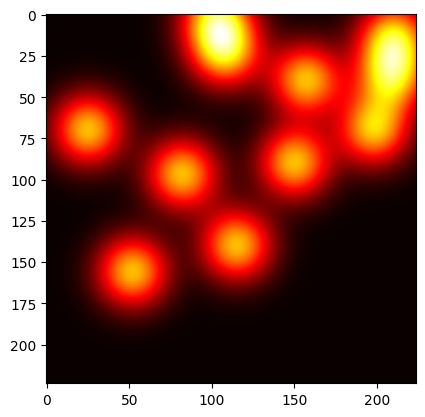

In [3]:
image = cv2.imread('Train_resized_2/img_0001_crop_0.jpg')
mat = scipy.io.loadmat('Train_resized_2/img_0001_crop_0.mat')
points = mat["annPoints"]
points = points.astype(int)

density_map = generate_density_map(image, points)
plt.imshow(density_map, cmap='hot')

In [4]:

class CrowdCounterResNet(nn.Module):
    def __init__(self):
        super(CrowdCounterResNet, self).__init__()

        # Load pretrained ResNet-18 and remove the classification layers
        resnet = models.resnet18(pretrained=True)
        self.backbone = nn.Sequential(*list(resnet.children())[:-2])  # Output: (B, 512, 7, 7)

        # Decoder: Upsample from (7x7) → (224x224)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),  # 7→14
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # 14→28
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),   # 28→56
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),    # 56→112
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),     # 112→224
            nn.ReLU()
        )

    def forward(self, x):
        x = self.backbone(x)
        x = self.decoder(x)
        return x

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = CrowdCounterResNet().to(device)
print(device)
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)

c:\Users\Adil\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Adil\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


cuda


In [6]:
class CrowdDataset(Dataset):
    def __init__(self, image_folder, density_map_folder, image_files, transform=None):
        self.image_folder = image_folder
        self.density_map_folder = density_map_folder
        self.image_files = image_files # Ensure sorted list
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Load image
        img_path = self.image_files[idx]
        # print(img_path)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        image = image.astype(np.float32) / 255.0  # Normalize to [0,1]

        # Load density map (.npy file)
        density_map_name = self.image_files[idx].replace('.jpg', '_density.npy').replace(self.image_folder, self.density_map_folder)  # or '.png' -> '.npy'
        density_map = np.load(density_map_name)  # Loads (H, W) float32 density map

        # Convert to torch tensors
        image = torch.from_numpy(image).permute(2, 0, 1)  # (C, H, W)
        density_map = torch.from_numpy(density_map).unsqueeze(0).float()  # (1, H, W)

        if self.transform:
            image = self.transform(image)

        return image, density_map

In [7]:
train_resized_folder = "Train_resized_2"
train_density_folder = "Train_density_2"

train_image_paths = []
train_heatmap_paths = []

# Iterate over files in Train_resized folder
for file_name in os.listdir(train_resized_folder):
    if file_name.endswith(".jpg"):
        train_image_paths.append(os.path.join(train_resized_folder, file_name))

# Iterate over files in Train_density folder
for file_name in os.listdir(train_density_folder):
    if file_name.endswith(".npy"):
        train_heatmap_paths.append(os.path.join(train_density_folder, file_name))

print(f"Found {len(train_image_paths)} images and {len(train_heatmap_paths)} heatmaps.")


validation_resized_folder = "Validation_resized_2"
validation_density_folder = "Validation_density_2"
validation_image_paths = []
validation_heatmap_paths = []

# Iterate over files in Validation_resized folder
for file_name in os.listdir(validation_resized_folder):
    if file_name.endswith(".jpg"):
        validation_image_paths.append(os.path.join(validation_resized_folder, file_name))

# Iterate over files in Validation_density folder
for file_name in os.listdir(validation_density_folder):
    if file_name.endswith(".npy"):
        validation_heatmap_paths.append(os.path.join(validation_density_folder, file_name))

print(f"Found {len(validation_image_paths)} images and {len(validation_heatmap_paths)} heatmaps.")

Found 4804 images and 4804 heatmaps.
Found 668 images and 668 heatmaps.


In [8]:
train_dataset = CrowdDataset(train_resized_folder, train_density_folder, train_image_paths)
validation_dataset = CrowdDataset(validation_resized_folder, validation_density_folder, validation_image_paths)

In [9]:
def train_model(model, train_loader, val_loader, num_epochs=20, lr=1e-5, device='cuda'):
    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for images, targets in train_loader:
            images = images.to(device)
            targets = targets.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            print("Target check:", targets.min(), targets.max(), targets.mean())
            break

        avg_train_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch {epoch+1} Training Loss: {avg_train_loss:.10f}")

        # Validation
        if val_loader:
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for images, targets in val_loader:
                    images = images.to(device)
                    targets = targets.to(device)
                    outputs = model(images)
                    loss = criterion(outputs, targets)
                    val_loss += loss.item() * images.size(0)

            avg_val_loss = val_loss / len(val_loader.dataset)
            print(f"Epoch {epoch+1} Validation Loss: {avg_val_loss:.10f}")

    # print("Sample outputs:", outputs[:5])
    # print("Sample targets:", targets[:5])
    return model


In [10]:
model = CrowdCounterResNet()

# Assuming you have these ready
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(validation_dataset, batch_size=4, shuffle=False)

trained_model = train_model(model, train_loader, val_loader, num_epochs=5)

Target check: tensor(0., device='cuda:0') tensor(255., device='cuda:0') tensor(57.7877, device='cuda:0')
Epoch 1 Training Loss: 6.0927161122
Epoch 1 Validation Loss: 6642.0930446255
Target check: tensor(0., device='cuda:0') tensor(255., device='cuda:0') tensor(42.5743, device='cuda:0')
Epoch 2 Training Loss: 4.0995662794
Epoch 2 Validation Loss: 6642.0234821605
Target check: tensor(0., device='cuda:0') tensor(255., device='cuda:0') tensor(57.1335, device='cuda:0')
Epoch 3 Training Loss: 6.5401655034
Epoch 3 Validation Loss: 6641.9518691436
Target check: tensor(0., device='cuda:0') tensor(255., device='cuda:0') tensor(57.9836, device='cuda:0')
Epoch 4 Training Loss: 6.1709537300
Epoch 4 Validation Loss: 6641.8808564419
Target check: tensor(0., device='cuda:0') tensor(255., device='cuda:0') tensor(54.6766, device='cuda:0')
Epoch 5 Training Loss: 6.4538023327
Epoch 5 Validation Loss: 6641.8062647210


In [112]:
model.eval()  # Set model to evaluation mode

# Load one image and one target
image, target = train_dataset[23]  # or any other index

# If your image is a tensor (C, H, W), add a batch dimension
image = image.unsqueeze(0).to(device)  # Shape becomes (1, C, H, W)

# Move target if needed
target = target.unsqueeze(0).to(device)  # optional if you want to check loss

# Pass through model
with torch.no_grad():
    output = model(image)

# Output is the predicted density map
print("Predicted output shape:", output.shape)
print("Predicted output min/max:", output.min().item(), output.max().item())

# If you want, compare with ground truth
print("Ground Truth min/max:", target.min().item(), target.max().item())


Predicted output shape: torch.Size([1, 1, 224, 224])
Predicted output min/max: 0.0 0.0
Ground Truth min/max: 0.0 255.0


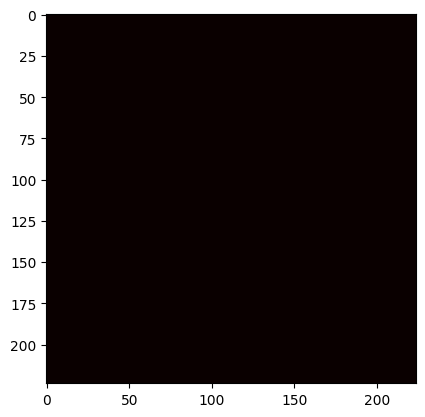

In [113]:
plt.imshow(output.squeeze().cpu().numpy(), cmap='hot')

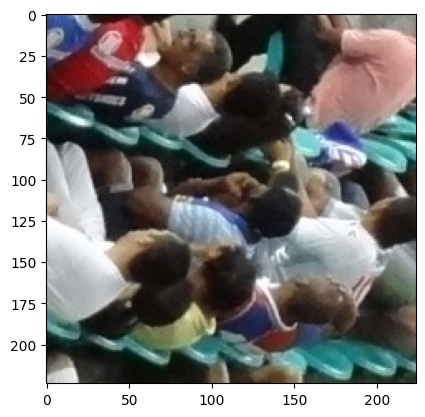

In [74]:
plt.imshow(image.squeeze().cpu().numpy().transpose(1, 2, 0))    

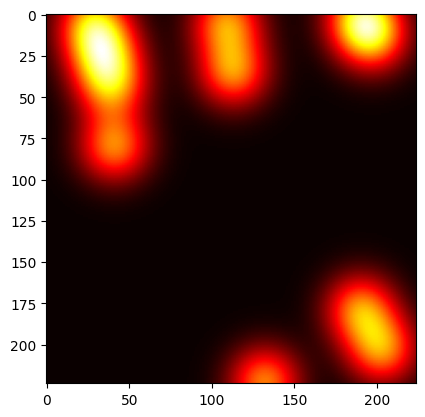

In [75]:
plt.imshow(target.squeeze().cpu().numpy(), cmap='hot')

In [114]:
model.eval()
with torch.no_grad():
    for images, targets in val_loader:
        images, targets = images.to(device), targets.to(device)
        outputs = model(images)
        print("Output min/max:", outputs.min().item(), outputs.max().item())
        print("Target min/max:", targets.min().item(), targets.max().item())
        break


Output min/max: 0.0 0.0
Target min/max: 0.0 255.0
